In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy
from sklearn.datasets import make_classification as Make
from sklearn.model_selection import train_test_split as split

In [8]:
from sklearn.datasets import fetch_lfw_pairs as lfwPairs

In [10]:
E = lfwPairs()

In [11]:
E

{'data': array([[ 73.666664,  71.      ,  82.      , ..., 224.66667 , 228.66667 ,
         231.66667 ],
        [ 85.      , 112.      , 132.66667 , ..., 106.      , 114.333336,
         122.      ],
        [ 37.      ,  35.333332,  34.      , ...,  51.333332,  52.333332,
          52.      ],
        ...,
        [ 73.      ,  94.333336, 121.333336, ...,  64.      ,  71.      ,
          82.      ],
        [119.      , 110.666664, 113.      , ..., 145.33333 , 130.      ,
         102.666664],
        [ 23.333334,  20.333334,  23.666666, ..., 146.66667 , 151.33333 ,
         159.      ]], dtype=float32),
 'pairs': array([[[[ 73.666664,  71.      ,  82.      , ..., 119.      ,
           118.333336, 118.666664],
          [ 70.      ,  70.333336,  86.333336, ..., 117.      ,
           111.666664, 107.      ],
          [ 71.666664,  76.666664,  97.333336, ..., 115.666664,
           114.      , 108.666664],
          ...,
          [154.33333 , 148.33333 , 162.33333 , ..., 155.33333 

In [14]:
E.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [22]:
len(E['target'])

2200

In [4]:
class logRegGD:
    def __init__(self,error, run, pltLength):
        self.weights_original = None # original copy to reference back to
        # generated test/train split
        self.xTrain = None
        self.yTrain = None
        self.xTest = None
        self.yTest = None
        self.weights = None # weights
        self.maxRunTime = run # cut off point for 
        self.initialTime = None # starting time
        self.time = None # time taken for a method run
        self.error = error # allowed error/epsilon
        self.grad = None # current gradient
        self.lamb = None # current step size
        self.gr_list = None # list of values of norms of gradient
        self.norm = None # current norm of gradient 
        self.theta = None # theta value used in Adpative
        self.preds = None # predicted classifications
        self.classi = None # proportion of correct classifications
        # Plots for different methods
        self.vanPlt = None
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = pltLength # maximum value for x axis in plt
    #-------------------------------------------------------------------------------------
    
    def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function
    
    def normalise(self, X): # normalises the input data to values between 0 and 1
        mins = np.min(X, axis = 0) 
        maxs = np.max(X, axis = 0) 
        rng = maxs - mins 
        norm_X = 1 - ((maxs - X)/rng) 
        return norm_X 
    
    
    
    def generate(self, samples, test_size): # generates sample data 
        sample_data = Make(n_samples=samples, random_state = 13)
        augmented_data = np.concatenate((np.array([[1]*len(sample_data[0])]).T,\
                                         self.normalise(sample_data[0])), axis =1)
        entire_set = list(sample_data)
        entire_set[0] = augmented_data
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( entire_set[0], entire_set[1], \
                                                                 test_size = test_size, random_state= 13)
        self.weights_original = np.random.rand(len(self.xTrain[0]),1)
    
    # in all methods used, we don't need f for any of them, just gradient(f)
    def cost_func(self, W): # function f: the inverse of the log likelihood function, modelling the probability of the data xTrain and xTest
        sig = self.sigmoid(W, self.xTrain)
        y = np.squeeze(self.yTrain)
        step1 = y * np.log(sig)
        step2 = (1 - y) * np.log(1 - sig) 
        final = -step1 - step2 
        return np.mean(final)
    
    def log_gradient(self, W): # the gradient function of f, simply (h(w) - y) * x
        sig = self.sigmoid(W, self.xTrain)
        inner_expr = np.squeeze(sig) - np.squeeze(self.yTrain.reshape(self.xTrain.shape[0],-1))
        return np.dot(inner_expr.T, self.xTrain )
    
    def GD(self): # Step size calculator - w_1 = w_0 - lam* gradient(w)
        self.weights = np.squeeze(self.weights) - self.lamb * self.log_gradient(self.weights)
    
    def calc_norm(self): # to calculate the norm of a gradient of a weight vector
        self.norm = np.linalg.norm(self.log_gradient(self.weights))
    
    def predict(self, beta, X):
        predP = self.sigmoid(beta, X) # predict classification probability 
        predVal = np.where(predP >= 0.5 , 1 , 0) # allocate most likely classifier
        self.preds = np.squeeze(predVal)
    
    
    #-------------------------------------------------------------------------------------------
    
    def Vanilla(self):
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_original) # make a copy of the weights
        self.gr_list = [] # create a list for recording norms of gradients
        self.lamb = 1/np.max( np.linalg.svd( self.xTrain @ self.xTrain.T )[1] ) # make step size using SVD
        count = 1
        self.calc_norm() # calculate norm of the gradient of the weights
        while self.norm > self.error: # start loop
            self.GD() # Step in steepest negative direction
            self.calc_norm()
            self.gr_list.append(self.norm)
            count += 1
            if time.time() - self.initialTime > self.maxRunTime: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0,  min(len(self.gr_list), self.Max ) , 'g', self.vanPlt, 'Vanilla {} sec'.format(self.time))
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.lamb = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldW = deepcopy(self.weights)
        self.GD()
        self.calc_norm()
        while self.norm > self.error:
            oldLam = deepcopy(self.lamb)
            min1 = np.sqrt(1 + self.theta)*self.lamb
            min2 = ( np.linalg.norm( self.weights - oldW ) ) \
            / ( 2 * np.linalg.norm( self.log_gradient(self.weights) - self.log_gradient(oldW)) )
            self.lamb = np.min([min1,min2])
            oldW = deepcopy(self.weights)
            self.GD()
            self.theta = self.lamb/oldLam
            self.calc_norm()
            self.gr_list.append(self.norm)
            if time.time() - self.initialTime > self.maxRunTime:
                break
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'y', self.AdapPlt, 'Adaptive {} sec'.format(self.time))
        self.PrintResults()
    
    def BackTrack(self):
        def normal(X): 
            return np.linalg.norm(X)
        rho = random.random()
        lam = random.randrange(1e6)
        while lam > ( normal( lam * self.grad ) / \
                     ( normal( self.log_gradient( np.squeeze(self.weights) - lam * self.grad ) - self.grad ) )  ):
            lam = rho * lam
        self.lamb = lam
                
    def LineSearch(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.calc_norm()
        self.grad = self.log_gradient(self.weights)
#         count = 1
        while self.norm > self.error:
            self.BackTrack()
            self.GD()
            self.grad = self.log_gradient(self.weights)
            self.calc_norm()
            self.gr_list.append(self.norm)
#             count +=1
            if time.time() - self.initialTime > self.maxRunTime:
                break
#         print(count)
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'b', self.LSPlt, 'LineSearch {} sec'.format(self.time))
        self.PrintResults()
        
    def Barzilai(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.lamb = random.random()+1e-12
        oldW = deepcopy(self.weights)
        self.GD()
        self.calc_norm()
        while self.norm > self.error:
            oldLam = deepcopy(self.lamb)
            self.lamb = np.dot( np.squeeze(self.weights - oldW), \
                               self.log_gradient(self.weights) - self.log_gradient(oldW) ) \
                        / np.linalg.norm( self.log_gradient(self.weights) - self.log_gradient(oldW) )**2
            oldX = deepcopy(self.weights)
            self.GD()
            self.calc_norm()
            self.gr_list.append( self.norm)
            if time.time() - self.initialTime > self.maxRunTime:
                break
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'r', self.BazPlt, 'Barzilai {} sec'.format(self.time))
        self.PrintResults()
    
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr_list[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient') # in domain [{}, {}]'.format(0, 600 ) )
        plt.savefig('logregplt.png', dpi=100)
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr_list), ':')
        print('weights vector is:', self.weights)
        print('Gradient Norm is:', self.norm)
        print('Time taken:', self.time)
        print('Final Lambda value: ', self.lamb)
        print('Percentage of points correctly classified: ', self.classi*100, "%")

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 74675 :
weights vector is: [ -9.36337703   0.33866555  10.22340698   0.75820125  -1.73194384
  -0.10751099   1.04081542  -0.75584536   0.9971392   -0.13058883
  -0.86383276  -0.20776309  -0.41141455  -0.8752774   -0.36582604
   0.3075461    0.94702195  18.85693661  -0.5171517  -10.01983675
  -0.67591431]
Gradient Norm is: 0.14712729674063307
Time taken: 30.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %


<ipython-input-4-2245d8b47c25>:29: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 7399 :
weights vector is: [ -9.91172996   0.39616526  10.34627415   0.8979271   -2.00312864
  -0.04117385   1.16040092  -0.72440154   1.15028877  -0.05662395
  -0.83231579  -0.15123087  -0.35719742  -0.78357331  -0.29828964
   0.434219     1.01267386  19.13877549  -0.45647737 -10.35846816
  -0.62503417]
Gradient Norm is: 9.825632743865946e-07
Time taken: 6.17
Final Lambda value:  0.00336535717904213
Percentage of points correctly classified:  94.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 1077 :
weights vector is: [ -9.89741497   0.39467072  10.34301369   0.89429787  -1.99606906
  -0.04287304   1.15728008  -0.72520814   1.14633759  -0.05855466
  -0.83312098  -0.15268739  -0.35862059  -0.785968    -0.30003733
   0.43090716   1.01098542  19.13132462  -0.45805507 -10.34959911
  -0.62636944]
Gradient Norm is: 0.004509107938490115
Tim

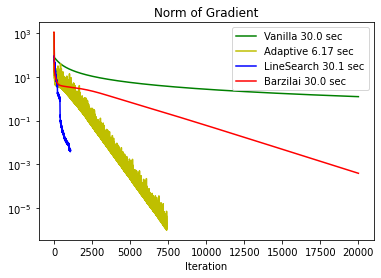

In [7]:
G = logRegGD(1e-6 , 30, 2*10**4)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

Ten iterations, logarithmic scale

epsilon = 0.1 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 20849 :
weights vector is: [-6.22561587  0.04256582  9.3584898   0.02379012 -0.56410442 -0.50221444
  0.42311936 -0.86459184  0.17156576 -0.45067373 -0.9853813  -0.52479257
 -0.61945765 -1.23687149 -0.66016969 -0.2618121   0.58199479 16.91960443
 -0.79719631 -8.32186719 -0.83504877]
Gradient Norm is: 1.201921437378414
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %


<ipython-input-28-b32c6f05f8df>:29: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2513 :
weights vector is: [-1.00769724e+01  4.35965682e-01  1.04657405e+01  9.94898938e-01
 -2.39016493e+00  4.70355909e-03  1.24378783e+00 -7.05270171e-01
  1.25543730e+00 -6.51602221e-03 -8.13552832e-01 -1.13072955e-01
 -3.20040356e-01 -7.22216859e-01 -2.53862457e-01  5.21729351e-01
  1.05646480e+00  1.93159441e+01 -4.15309422e-01 -1.08195936e+01
 -5.91846752e-01]
Gradient Norm is: 0.09948917724965174
Time taken: 2.33
Final Lambda value:  0.003829004126344555
Percentage of points correctly classified:  94.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 71 :
weights vector is: [-1.63357227 -0.18330003  5.04015068 -0.64268662  0.36337362 -0.79475847
 -0.13416527 -0.62414367 -0.50361621 -0.21580918 -0.67321743 -0.6836795
 -0.31957141 -0.76776731 -0.55584344 -0.24999526 -0.07060998  8.64051399
 -0.78202137 -3.56444536 -0.46269836]
Grad

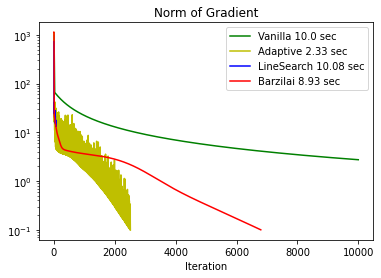

epsilon = 0.01 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 21145 :
weights vector is: [-6.86781397  0.04453002  9.61700316  0.03242958  0.05576266 -0.49544676
  0.42854437 -0.86367898  0.18669701 -0.45042795 -0.98612751 -0.52081191
 -0.6179171  -1.23355278 -0.65652057 -0.25612397  0.59053562 16.81303356
 -0.79476623 -7.90360312 -0.83375715]
Gradient Norm is: 1.1834766548405895
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 1909 :
weights vector is: [-10.25896054   0.3922101   10.60485834   0.88832915  -1.54805028
  -0.04567192   1.15214891  -0.7265436    1.13983555  -0.06173409
  -0.83445475  -0.15508728  -0.3609643   -0.78991194  -0.30291842
   0.42545936   1.00820314  

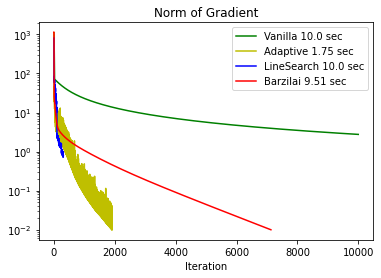

epsilon = 0.001 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 21114 :
weights vector is: [-6.66215285  0.04749806  8.87802016  0.03627401 -0.36231047 -0.49626223
  0.43321032 -0.86073553  0.18578245 -0.44586771 -0.98118435 -0.51786349
 -0.61601173 -1.22661752 -0.65339876 -0.25145839  0.59166432 17.36667599
 -0.79195971 -7.73801243 -0.83094289]
Gradient Norm is: 1.1819512528333176
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4069 :
weights vector is: [-10.08181606   0.39656176   9.87870857   0.89889136  -1.97839301
  -0.04071854   1.1612291   -0.72419688   1.1513386   -0.05611807
  -0.83211252  -0.15084612  -0.35682418  -0.78294947  -0.29783469
   0.43509305   1.01311804 

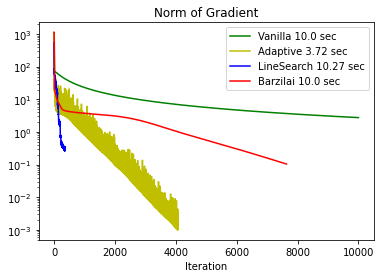

epsilon = 0.0001 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 20901 :
weights vector is: [-6.56830962  0.04256401  9.03138164  0.01970673 -0.30922215 -0.5052553
  0.42180065 -0.86506317  0.16468967 -0.4527263  -0.98565411 -0.52654146
 -0.62246054 -1.24253825 -0.66215586 -0.2672524   0.57983941 17.20597871
 -0.79920703 -7.80892239 -0.83672988]
Gradient Norm is: 1.206436553558166
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4346 :
weights vector is: [-10.0499648    0.39612525  10.04255828   0.89782981  -1.9566678
  -0.04121979   1.16031735  -0.72442221   1.15018284  -0.056675
  -0.83233632  -0.1512697   -0.35723509  -0.78363628  -0.29833556
   0.43413081   1.01262904  19.

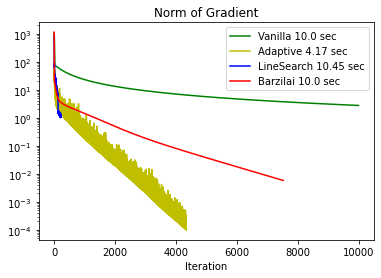

In [29]:
for i in range(1,5):
    G = logRegGD(10**(-i) , 10, 10**4)
    G.generate(1000, 0.1)
    print("epsilon =", 10**(-i), ", \nallowed time =", 10, " seconds")
    print("##_____________________________________________________________________##")
    G.Vanilla()
    G.Adaptive()
    G.LineSearch()
    G.Barzilai()
    G.PrintPlots()

Five iterations, logarithmic scale

epsilon = 0.1 , 
allowed time = 15  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 39418 :
weights vector is: [-15.47866434  -0.08327419  12.97120425   0.18517643  -0.65840735
   0.97928547  -0.40586421   0.25878919   1.31619643   0.21993512
   0.14584561  -0.04435746  -0.07392422  -0.77997806   0.5077678
  -1.01706889   2.7130574    0.18079599   2.958318    -2.23937093
  13.28268529]
Gradient Norm is: 0.9296334575431787
Time taken: 15.0
Final Lambda value:  0.00017585084236340878
Percentage of points correctly classified:  87.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3505 :
weights vector is: [-20.63800541   0.24780854  15.38810447   0.69493623  -0.51344031
   1.57229538   0.19281497   0.65084395   1.56522192   0.65659198
   0.21544402   0.22851002   0.44551385  -0.59818002   1.04751945
  -1.01359338   2.91531929   0.70981089   2.37422534  -2.04234437
  15.70766247]
Gradient Norm is: 0.09973175434652759
Time taken: 2.7
Final Lambda value:  0.0031225504167791207
Percentage of points correctly classified:  87.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 557 :
weights vector is: [-17.01622391   0.02027234  13.66107056   0.34883767  -0.60881913
   1.1724238   -0.21112981   0.37622408   1.39325503   0.352607
   0.16810085   0.04274225   0.07928378  -0.72083267   0.67236323
  -1.01442849   2.75636369   0.34349015   2.76653393  -2.16178969
  13.97492745]
Gradient Norm is: 0.668788705492041
Time taken

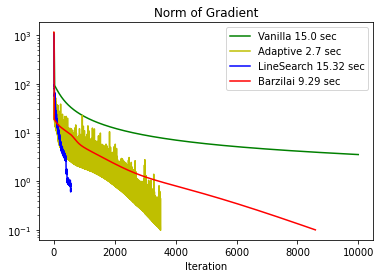

epsilon = 0.01 , 
allowed time = 30  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 61701 :
weights vector is: [-3.72151625  0.41808347  0.68540925 -0.76494779 17.30983889 -0.02552924
 -0.63796743  0.26682967 -0.67220449  3.96821422 -0.38613223 -5.30778612
  1.16500245  0.42280368 -0.58489062 -0.4925009  -2.0459384   0.20403246
 -0.63865925 -2.88892682 -0.22048274]
Gradient Norm is: 0.009999767993436335
Time taken: 23.08
Final Lambda value:  0.000199079619862159
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2270 :
weights vector is: [-3.74572642  0.42556239  0.69480804 -0.76147031 17.33146063 -0.02252939
 -0.63463123  0.2752152  -0.67092134  3.96649998 -0.38317208 -5.32287251
  1.16788934  0.42833027 -0.58242432 -0.49142934 -2.0443705   0.21181303
 -0.63

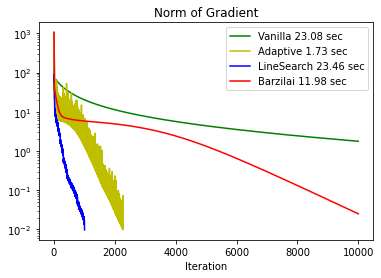

epsilon = 0.001 , 
allowed time = 45  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 116996 :
weights vector is: [-9.32750889 -0.07784469  0.49576113  0.57856713  5.86055605 -0.74868675
  1.01929957 -0.38811366  0.57790274  0.16705814  5.26545192  1.2266124
  0.97443626 -0.58516387  5.81079693 -0.26388519 -0.87834483  0.95537392
 -1.02518938 -0.7905964  -0.17437301]
Gradient Norm is: 0.0009999567392222767
Time taken: 43.18
Final Lambda value:  0.00017688540345140588
Percentage of points correctly classified:  84.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4208 :
weights vector is: [-9.33221964 -0.07744727  0.49619533  0.57908352  5.8610132  -0.74839205
  1.01981973 -0.38771105  0.57853327  0.16747672  5.26602116  1.22726802
  0.97503303 -0.58478754  5.81110566 -0.2635889  -0.87788317  0.95589206
 -

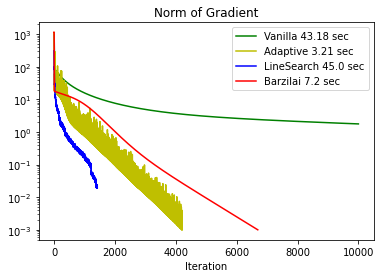

epsilon = 0.0001 , 
allowed time = 60  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 113154 :
weights vector is: [ -2.03577745  -0.63811338   5.66947805   1.53360247   0.15746489
   0.52214458   0.2894102   -0.86361159  12.0094521   -0.70743476
   0.16924969  -0.31046751   1.36075577  -1.29659145  -0.70678508
  -0.03683104  -1.08811658 -11.75982634   1.19277956  -0.60973381
   0.3320069 ]
Gradient Norm is: 9.999270320336075e-05
Time taken: 41.75
Final Lambda value:  0.00016986641522217684
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3266 :
weights vector is: [ -2.03595116  -0.63807326   5.66949434   1.53363857   0.15751598
   0.5221949    0.28947445  -0.86358957  12.00953814  -0.70741899
   0.16927847  -0.31045539   1.36082416  -1.29672122  -0.70675517

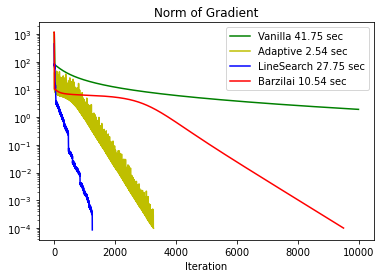

epsilon = 1e-05 , 
allowed time = 75  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 200828 :
weights vector is: [  3.30032061 -12.73329831  -0.57589108  -0.62710692  -0.60685032
   0.79963442  -4.13305835  17.86072879  -2.09391071  -0.94568908
   0.69586548  -2.64681429   3.8090133   -0.13231121   0.66407593
   0.8064575    0.06929732   1.09047775  -2.29166489  -0.44463568
   0.93860003]
Gradient Norm is: 0.00036778078765789855
Time taken: 75.0
Final Lambda value:  0.00018863026250739672
Percentage of points correctly classified:  92.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4595 :
weights vector is: [  3.30100646 -12.73379859  -0.57601846  -0.62730864  -0.60705525
   0.79959992  -4.13309251  17.86197959  -2.09420151  -0.9458525
   0.69577456  -2.64708912   3.80942616  -0.13239685   0.66411821
 

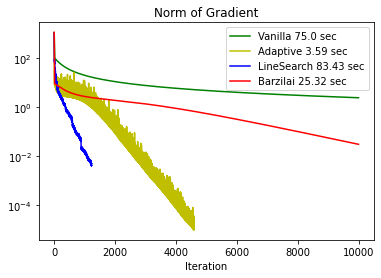

In [18]:
for i in range(1,6):
    G = logRegGD(10**(-i) , 15*i, 10**4)
    G.generate(1000, 0.1)
    print("epsilon =", 10**(-i), ", \nallowed time =", 15*i, " seconds")
    print("##_____________________________________________________________________##")
    G.Vanilla()
    G.Adaptive()
    G.LineSearch()
    G.Barzilai()
    G.PrintPlots()

One iterations, $ \epsilon < 10^{-1}$, 15 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 39190 :
weights vector is: [-11.3701796   16.9184937    0.49099119  -0.59191859   2.51388772
   0.50259873   0.34189022   0.3330157   -0.29125516  -0.71322257
   0.64256127  -1.08144477  -0.44533297   0.22530737   6.72544529
  -0.28854479  -3.11007145  -1.9577218    0.37949478  -0.25289226
  -0.7846777 ]
Gradient Norm is: 0.5832665136716818
Time taken: 15.0
Final Lambda value:  0.00017156150707073328
Percentage of points correctly classified:  86.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 1860 :
weights vector is: [-13.32902009  18.25364561   0.79221631  -0.44615027   2.18926056
   0.76970979   0.50453468   0.5659366   -0.14491914  -0.58928196
   0.87160198  -1.06791629  -0.31552764   0.43623467   7.28472097
  -0.20114224  -3.58384677  -1.90198509   0.56857185  -0.0497695
  -0.73553277]
Gradient Norm is: 0.09963918239142554
Time taken: 1.42
Final Lambda value:  0.002056616475093286
Percentage of points correctly classified:  86.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 430 :
weights vector is: [-8.12214827e+00  1.47978662e+01  5.67075210e-04 -8.63437436e-01
  3.10301816e+00  2.43516317e-02  6.32384518e-02 -4.81690234e-02
 -5.52086872e-01 -9.31389730e-01  2.63827014e-01 -1.13406192e+00
 -6.65889332e-01 -1.36880697e-01  5.82868587e+00 -4.54561706e-01
 -2.33238442e+00 -2.05335751e+00  5.27177612e-02 -5.91781945e-01

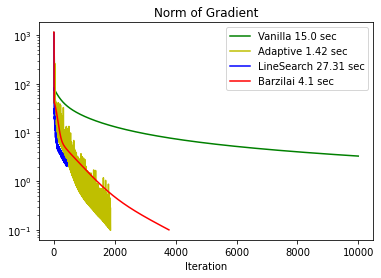

In [8]:
G = logRegGD(1e-1 , 15, 10**4)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

One iterations, $ \epsilon < 10^{-3}$, 30 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 20366 :
weights vector is: [-6.76952939e+00  3.90163583e-02  9.34910100e+00  1.08632115e-02
  2.36395929e-02 -5.10944853e-01  4.13825234e-01 -8.61001266e-01
  1.55877619e-01 -4.52439346e-01 -9.82432142e-01 -5.31017188e-01
 -6.19753580e-01 -1.23323968e+00 -6.59941686e-01 -2.66928128e-01
  5.78389637e-01  1.68883238e+01 -7.99353487e-01 -7.72812981e+00
 -8.31466024e-01]
Gradient Norm is: 1.2366263232510022
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %


<ipython-input-28-b32c6f05f8df>:29: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4351 :
weights vector is: [-10.29315274   0.39656205  10.39551631   0.89889208  -1.63623798
  -0.04071821   1.16122971  -0.72419673   1.15133937  -0.05611769
  -0.83211238  -0.15084584  -0.35682391  -0.78294901  -0.29783436
   0.43509369   1.01311837  19.13776864  -0.45606225 -10.02967775
  -0.62469085]
Gradient Norm is: 0.0009998566058553675
Time taken: 4.1
Final Lambda value:  0.0039031643829538095
Percentage of points correctly classified:  94.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 449 :
weights vector is: [-9.66206113  0.32169724 10.44092309  0.72477743 -1.2651124  -0.10484488
  1.01175699 -0.80853515  0.96021594 -0.19123845 -0.91670027 -0.21917946
 -0.46262205 -0.97049409 -0.42642388  0.2325034   0.92952823 19.13100059
 -0.55638282 -9.73001837 -0.75127684]
Gradient Norm is: 0.2957105507608952
Time taken: 10.2
Final Lamb

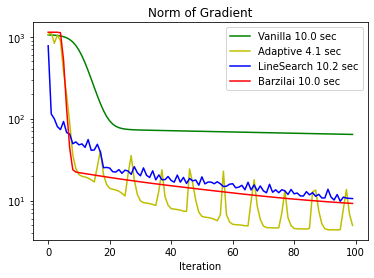

In [30]:
G = logRegGD(1e-3 , 10, 100)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

One iterations, $ \epsilon < 10^{-6}$, 60 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 164040 :
weights vector is: [-1.59926765e+01 -9.97314385e-01 -5.98851396e-01  1.44763622e+00
 -8.12062011e-02  6.73154351e-01 -5.47256403e-01  1.66570914e+01
  1.12132665e+00  4.71680790e+00 -9.90048943e-02 -1.20520221e+01
  2.99490621e-01  9.81301405e-02  8.81485654e-02 -2.19672620e-01
 -4.70798029e-01  2.65720530e+00  4.36148790e-01  2.55759699e+01
  2.15136486e-02]
Gradient Norm is: 0.05504849255050246
Time taken: 60.0
Final Lambda value:  0.00018973892080890458
Percentage of points correctly classified:  90.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 12561 :
weights vector is: [-16.26932173  -1.01187947  -0.61032088   1.48558102  -0.06084642
   0.69534958  -0.54969767  16.86681822   1.15656571   4.75795893
  -0.08098138 -12.2509196    0.31773433   0.11586477   0.09731235
  -0.20213984  -0.46803852   2.71701533   0.45521177  25.92930351
   0.03579833]
Gradient Norm is: 9.992183014771204e-07
Time taken: 9.62
Final Lambda value:  0.005300012835674103
Percentage of points correctly classified:  90.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 2323 :
weights vector is: [-16.17735896  -1.00694844  -0.60643096   1.47294491  -0.06759888
   0.68799235  -0.5488333   16.79680403   1.14483469   4.74405596
  -0.08694626 -12.18469738   0.31172129   0.10999016   0.09431242
  -0.20794432  -0.46890947   2.69719113   0.44887926  25.81140164
   0.03108517]
Gradient Norm is: 0.02000869137557162
Ti

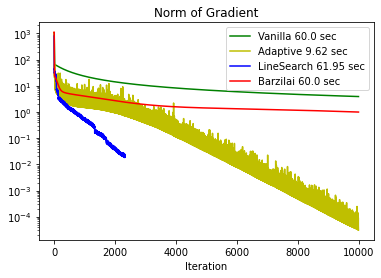

In [7]:
G = logRegGD(1e-6 , 60, 10**4)
G.generate(1000,0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()